In [2]:
import os
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn
from sklearn.utils import Bunch

import proxbias as pb

# This is necesary for the svg output plots to have editable text
plt.rcParams["svg.fonttype"] = "none"

# Just to make the notebook take up full screen real estate, not necessary
from IPython.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))

# Load JUMP cpg0016 data

cpg0016 data loading and PCA transforming is shown in `cpg0016_loading.ipynb`. This code assumes that has already been run to create a directory `scratch` in the high-level `proxbias` directory and populate it with `cpg_data_dict.pkl`.

In [3]:
with open("../../scratch/cpg_data_dict.pkl", "rb") as infile:
    data_dict = pickle.load(infile)
data_dict.keys()

dict_keys(['JUMP-CP PCAW', 'JUMP-CP PCAW Arm-Centered'])

In [4]:
data_dict["JUMP-CP PCAW"].metadata.head()

gene chromosome  chr_idx chromosome_arm  gene_bp     zfpkm
0     HES4       chr1        1          chr1p   998963 -4.060299
1   RNF223       chr1        1          chr1p  1070966 -3.780112
2  TNFRSF4       chr1        1          chr1p  1211339 -2.613715
3  B3GALT6       chr1        1          chr1p  1232236 -0.488317
4   UBE2J2       chr1        1          chr1p  1253911  0.723001

In [5]:
jump_data = data_dict["JUMP-CP PCAW"]
jump_data_pbr = data_dict["JUMP-CP PCAW Arm-Centered"]

In [6]:
print("JUMP genes:", jump_data.metadata.groupby("gene").size().value_counts())
print("JUMP PBR genes:", jump_data_pbr.metadata.groupby("gene").size().value_counts())

JUMP genes: 1    7825
dtype: int64
JUMP PBR genes: 1    7825
dtype: int64


# Make pairwise dataframes of cosine similarity

### First we "harmonize" data between two sources.
This isn't strictly necessary since the JUMP data and PBR corrected JUMP data have the same genes, but we'll demonstrate the function for other use cases.

In [7]:
from proxbias.utils.df_tools import harmonize_data, make_pairwise_cos, make_split_cosmat

In [8]:
jump_df, jump_pbr_df = harmonize_data(jump_data, jump_data_pbr, kind="intersection")
print("shapes", jump_df.shape, jump_pbr_df.shape)

7825 genes in dataset1 7825 genes in dataset2, 7825 in the intersection
shapes (7825, 154) (7825, 154)


### Make pairwise cosine matrices

In [9]:
jump_mat = make_pairwise_cos(jump_df)
jump_pbr_mat = make_pairwise_cos(jump_pbr_df)

### Make and plot a split heatmap (non-normalized data)

In [10]:
from proxbias.plotting.heatmaps import plot_heatmap

In [11]:
split_mat = make_split_cosmat(jump_mat, jump_pbr_mat)

In [12]:
path = "plots"
if not os.path.exists(path):
    os.mkdir(path)

cpg0016 (upper) prox-bias reduced (lower) unnormalized


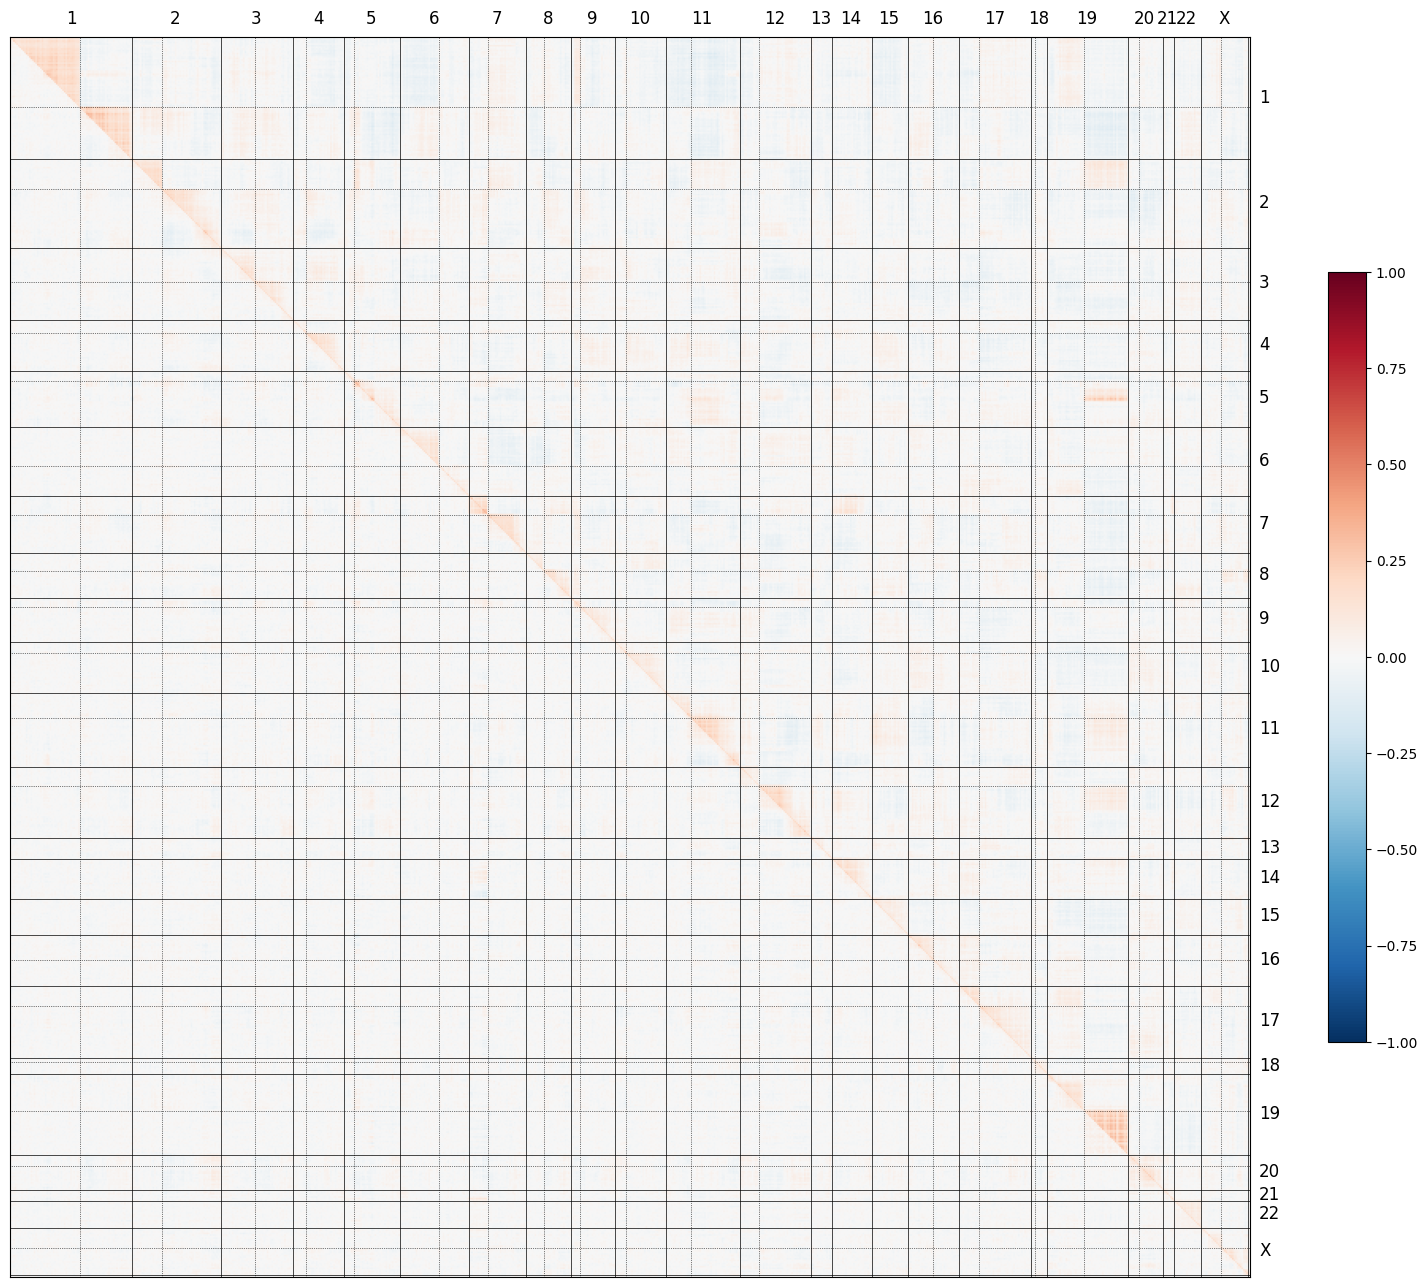

In [13]:
print("cpg0016 (upper) prox-bias reduced (lower) unnormalized")
plot_heatmap(
    split_mat, f_name=os.path.join(path, "cpg0016_split_prenorm.svg"), format="svg", crunch_factor=10, title=""
)

### Quantile normalize both dataframes and replot
To fit a `N(0, 0.2)` distribution

In [14]:
from proxbias.utils.q_norm import q_norm

In [15]:
jump_mat_norm = q_norm(jump_mat)
jump_mat_pbr_norm = q_norm(jump_pbr_mat)

In [16]:
split_mat_norm = make_split_cosmat(jump_mat_norm, jump_mat_pbr_norm)

cpg0016 (upper) prox-bias reduced (lower) unnormalized


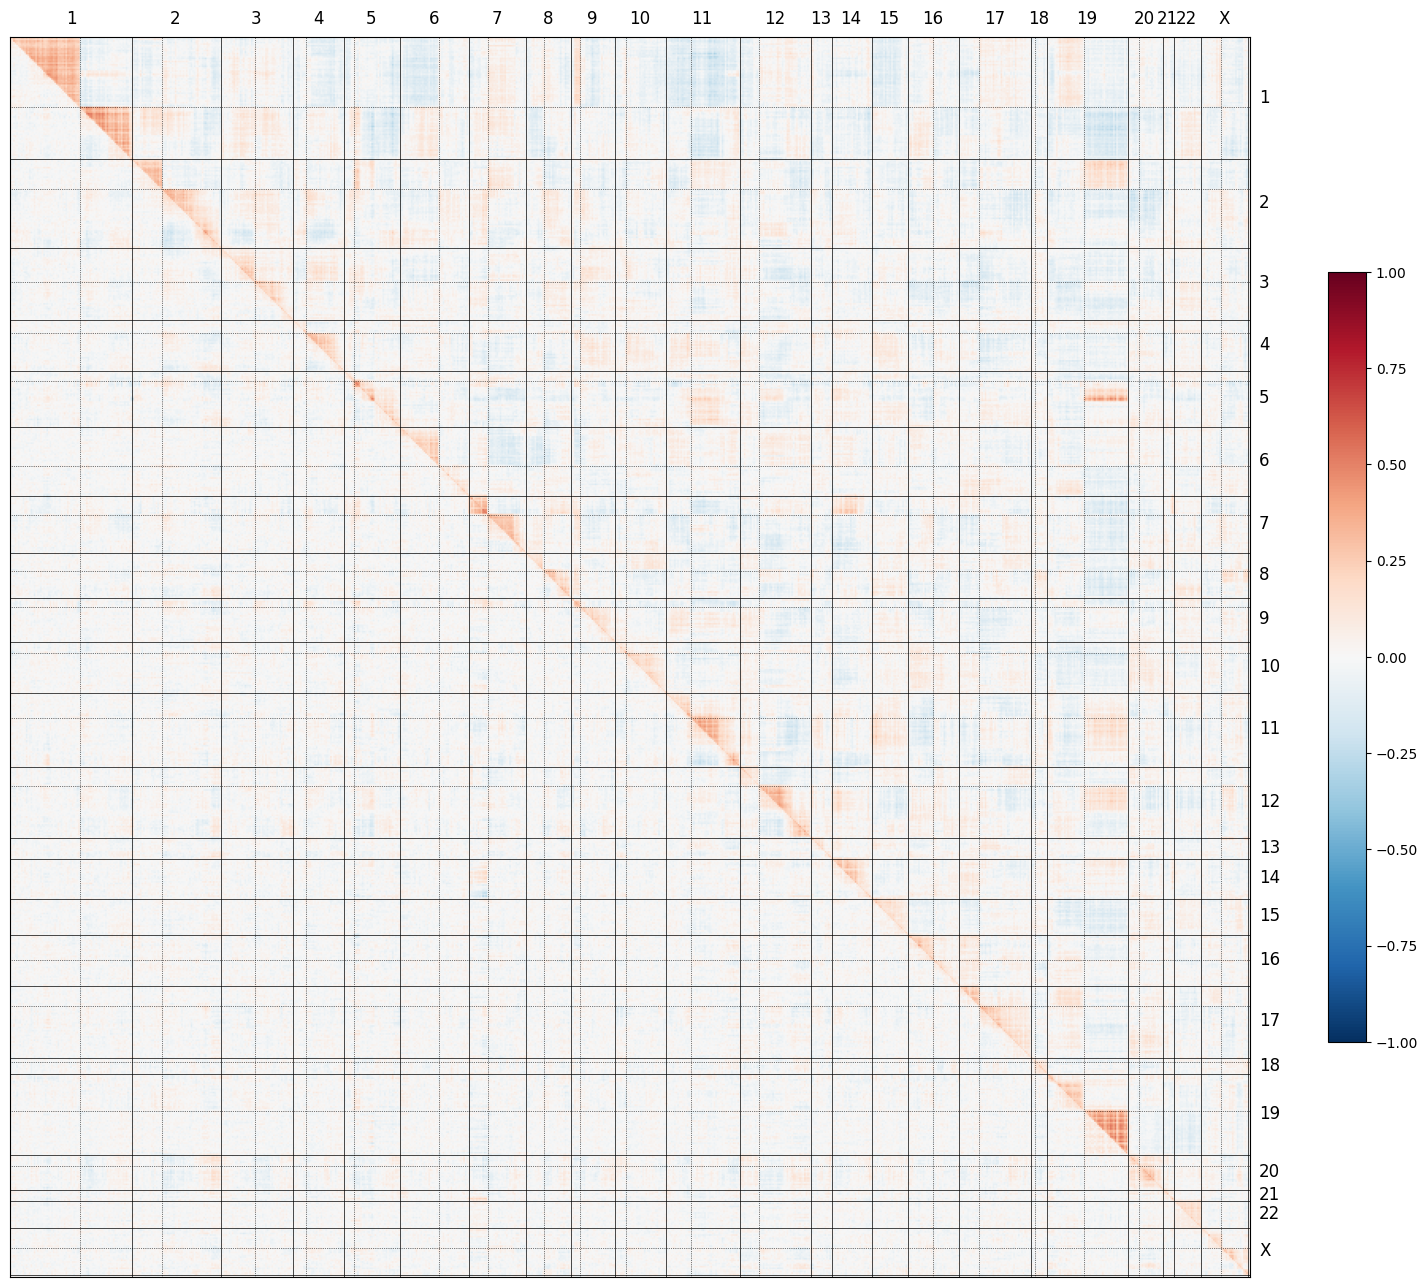

In [17]:
print("cpg0016 (upper) prox-bias reduced (lower) unnormalized")
plot_heatmap(
    split_mat_norm, f_name=os.path.join(path, "cpg0016_split_norm.svg"), format="svg", crunch_factor=10, title=""
)

### Zoom in on chromosome 8

cpg0016 (upper) prox-bias reduced (lower) unnormalized


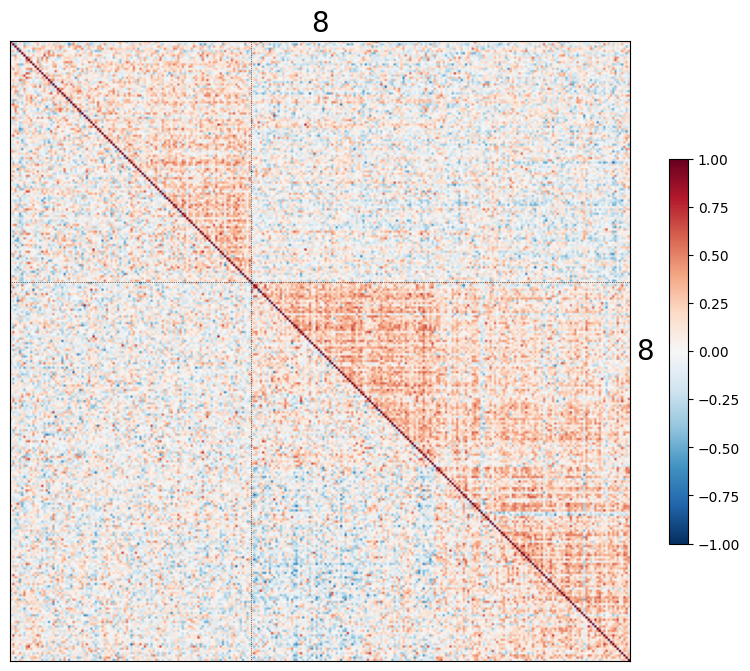

In [18]:
print("cpg0016 (upper) prox-bias reduced (lower) unnormalized")
idx = split_mat_norm.index.get_level_values("chromosome") == "chr8"
plot_heatmap(
    split_mat_norm.loc[idx, idx],
    f_name=os.path.join(path, "cpg0016_split_norm_chr8.svg"),
    format="svg",
    crunch_factor=1,
    title="",
    lab_s=20,
    figsize=(10, 10),
)

### Show chromosome 8 clustered by the non-prox-bias corrected similarities
Note: You can't just cluster by the split matrix because when you sort both rows and columns some values that were below the diagonal may get shuffled to above the diagonal (we learned this the hard way). So we built some helper functions.

In [19]:
from proxbias.utils.df_tools import mk_gene_mats

In [20]:
split_mat_norm.iloc[:10, :10]

gene                                                    HES4    RNF223  \
chromosome                                              chr1      chr1   
chromosome_arm                                         chr1p     chr1p   
chr_idx                                                    1         1   
gene_bp                                              998963    1070966   
gene     chromosome chromosome_arm chr_idx gene_bp                       
HES4     chr1       chr1p          1       998963   1.000000  0.257404   
RNF223   chr1       chr1p          1       1070966  0.011961  1.000000   
TNFRSF4  chr1       chr1p          1       1211339 -0.285376  0.345720   
B3GALT6  chr1       chr1p          1       1232236  0.210440 -0.232693   
UBE2J2   chr1       chr1p          1       1253911  0.539216  0.064527   
SCNN1D   chr1       chr1p          1       1280435  0.314480  0.271317   
PUSL1    chr1       chr1p          1       1308596  0.192548  0.032441   
AURKAIP1 chr1       chr1p          1       1373735  0.375697 -0.064534   
MIB2     chr1       chr1p          1       1613730  0.450118  0.188338   
MMP23B   chr1       chr1p          1       1632172 -0.101628 -0.101696   

gene                                                 TNFRSF4   B3GALT6  \
chromosome                                              chr1      chr1   
chromosome_arm                                         chr1p     chr1p   
chr_idx                                                    1         1   
gene_bp                                              1211339   1232236   
gene     chromosome chromosome_arm chr_idx gene_bp                       
HES4     chr1       chr1p          1       998963  -0.271603  0.385886   
RNF223   chr1       chr1p          1       1070966  0.246581 -0.092993   
TNFRSF4  chr1       chr1p          1       1211339  1.000000 -0.054847   
B3GALT6  chr1       chr1p          1       1232236  0.111215  1.000000   
UBE2J2   chr1       chr1p          1       1253911 -0.142382  0.421279   
SCNN1D   chr1       chr1p          1       1280435 -0.313906  0.243330   
PUSL1    chr1       chr1p          1       1308596 -0.304944  0.202471   
AURKAIP1 chr1       chr1p          1       1373735 -0.532512 -0.181595   
MIB2     chr1       chr1p          1       1613730 -0.027202  0.112602   
MMP23B   chr1       chr1p          1       1632172  0.158954  0.205702   

gene                                                  UBE2J2    SCNN1D  \
chromosome                                              chr1      chr1   
chromosome_arm                                         chr1p     chr1p   
chr_idx                                                    1         1   
gene_bp                                              1253911   1280435   
gene     chromosome chromosome_arm chr_idx gene_bp                       
HES4     chr1       chr1p          1       998963   0.613840  0.543863   
RNF223   chr1       chr1p          1       1070966  0.193547  0.458717   
TNFRSF4  chr1       chr1p          1       1211339 -0.266835 -0.243968   
B3GALT6  chr1       chr1p          1       1232236  0.465079  0.435847   
UBE2J2   chr1       chr1p          1       1253911  1.000000  0.335730   
SCNN1D   chr1       chr1p          1       1280435  0.086935  1.000000   
PUSL1    chr1       chr1p          1       1308596  0.312297  0.282596   
AURKAIP1 chr1       chr1p          1       1373735  0.300200  0.199505   
MIB2     chr1       chr1p          1       1613730  0.434126  0.386969   
MMP23B   chr1       chr1p          1       1632172  0.360048 -0.002830   

gene                                                   PUSL1  AURKAIP1  \
chromosome                                              chr1      chr1   
chromosome_arm                                         chr1p     chr1p   
chr_idx                                                    1         1   
gene_bp                                              1308596   1373735   
gene     chromosome chromosome_arm chr_idx gene_bp                       
H

In [21]:
chr8_genes = list(split_mat_norm.loc[idx, idx].index.get_level_values("gene"))
chr8_split_mat, chr8_norm, chr8_pbr_norm, chr8_norm_clust, chr8_pbr_norm_clust = mk_gene_mats(
    chr8_genes, split_mat_norm, jump_mat_norm, jump_mat_pbr_norm
)

cpg0016 (upper) prox-bias reduced (lower) clustered by the uncorrected data


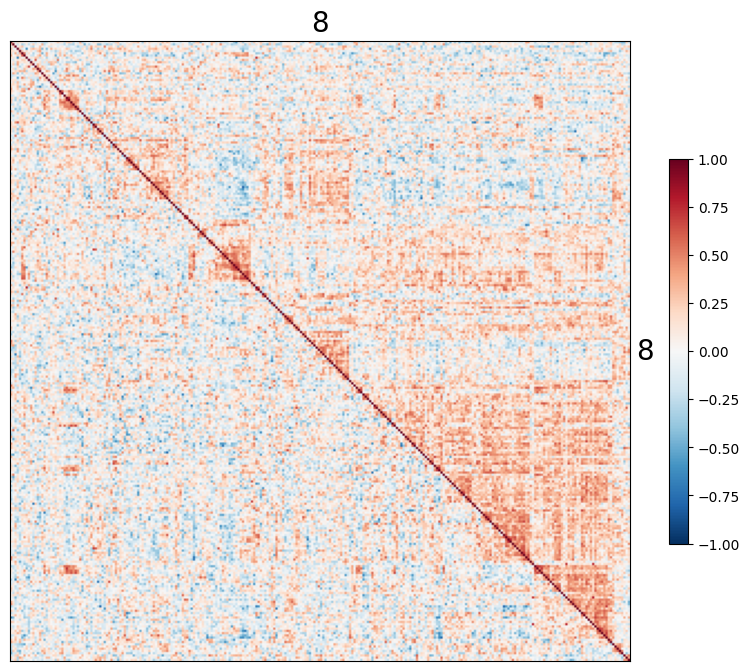

In [22]:
print("cpg0016 (upper) prox-bias reduced (lower) clustered by the uncorrected data")
plot_heatmap(
    chr8_norm_clust,
    f_name=os.path.join(path, "cpg0016_split_norm_chr8_clust1.svg"),
    format="svg",
    crunch_factor=1,
    title="",
    lab_s=20,
    figsize=(10, 10),
)

cpg0016 (upper) prox-bias reduced (lower) clustered by the prox-bias corrected data


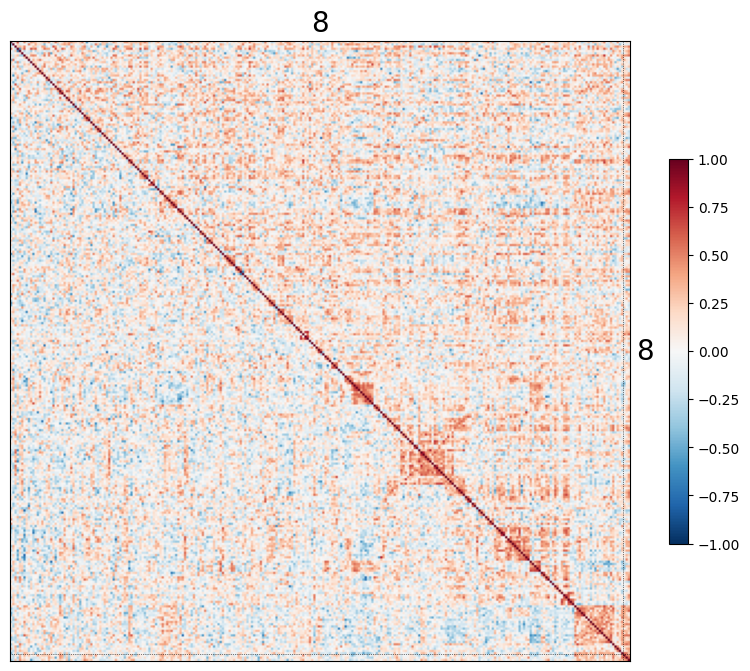

In [23]:
print("cpg0016 (upper) prox-bias reduced (lower) clustered by the prox-bias corrected data")
plot_heatmap(
    chr8_pbr_norm_clust,
    f_name=os.path.join(path, "cpg0016_split_norm_chr8_clust2.svg"),
    format="svg",
    crunch_factor=1,
    title="",
    lab_s=20,
    figsize=(10, 10),
)

### Look at a set of genes in figure 1B
For these strong genes, the prox-bias correction doesn't do much, the real biological signals are still present.

In [24]:
cust_genes = (
    "ACVR1B, TGFBR2, TGFBR1, PSMB2, PSMB7, PSMB4, PSMA7, PSMA4, PSMB6, PSMA5, PSMB3, PSMA6, PSMA1, PSMB1, PSMA3, "
    "DIS3, EXOSC4, EXOSC8, EXOSC7, EXOSC9, EXOSC5, RFC3, RFC4, RFC2, RFC5, POLA2, POLA1, POLR2L, POLR2B, POLR2I, "
    "POLR2G, POLR2C, DYNC1I2, DYNC1H1, DYNC1LI1, DYNC1LI2, ATP6V1B2, ATP6V1H, ATP6V1D, ATP6V1A, ATP6V1F, ATP6V1E1, "
    "PRKCE, BRAF, HRAS, SHC1, RAF1, EGFR, MAPK1, ATG12, ATG5"
).split(", ")

In [25]:
cust_split_mat, cust_norm, cust_pbr_norm, cust_norm_clust, cust_pbr_norm_clust = mk_gene_mats(
    cust_genes, split_mat_norm, jump_mat_norm, jump_mat_pbr_norm
)

cpg0016 (upper) prox-bias reduced (lower) clustered by the uncorrected data


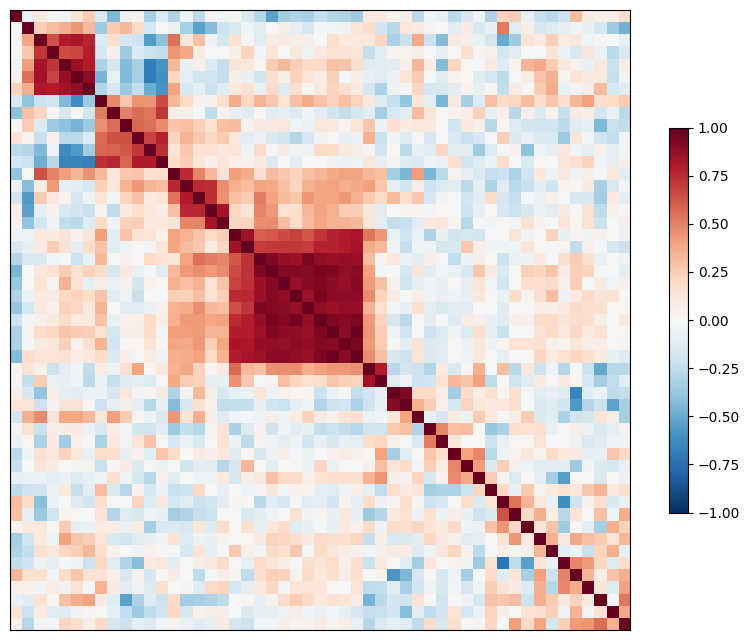

In [26]:
print("cpg0016 (upper) prox-bias reduced (lower) clustered by the uncorrected data")
plot_heatmap(
    cust_norm_clust,
    f_name=os.path.join(path, "cpg0016_split_norm_custom_clust1.svg"),
    format="svg",
    crunch_factor=1,
    title="",
    lab_s=20,
    figsize=(10, 10),
    show_chr_lines=False,
    show_cent_lines=False,
    show_chroms=False,
    show_chrom_arms=False,
)

In [27]:
cust_norm_clust.iloc[:5, :5]

gene                                                  DYNC1LI2    EXOSC5  \
chromosome                                               chr16     chr19   
chromosome_arm                                          chr16q    chr19q   
chr_idx                                                     16        19   
gene_bp                                              66720892  41386373    
gene     chromosome chromosome_arm chr_idx gene_bp                         
DYNC1LI2 chr16      chr16q         16      66720892   1.000000 -0.075987   
EXOSC5   chr19      chr19q         19      41386373   0.005450  1.000000   
EXOSC9   chr4       chr4q          4       121801322  0.026657  0.391270   
DIS3     chr13      chr13q         13      72752168  -0.007495  0.271550   
EXOSC7   chr3       chr3p          3       44976243  -0.028111  0.421666   

gene                                                    EXOSC9      DIS3  \
chromosome                                                chr4     chr13   
chromosome_arm                                           chr4q    chr13q   
chr_idx                                                     4         13   
gene_bp                                              121801322 72752168    
gene     chromosome chromosome_arm chr_idx gene_bp                         
DYNC1LI2 chr16      chr16q         16      66720892   0.097201  0.032192   
EXOSC5   chr19      chr19q         19      41386373   0.254143  0.307141   
EXOSC9   chr4       chr4q          4       121801322  1.000000  0.641417   
DIS3     chr13      chr13q         13      72752168   0.713417  1.000000   
EXOSC7   chr3       chr3p          3       44976243   0.820394  0.716800   

gene                                                    EXOSC7  
chromosome                                                chr3  
chromosome_arm                                           chr3p  
chr_idx                                                     3   
gene_bp                                              44976243   
gene     chromosome chromosome_arm chr_idx gene_bp              
DYNC1LI2 chr16      chr16q         16      66720892  -0.023996  
EXOSC5   chr19      chr19q         19      41386373   0.367095  
EXOSC9   chr4       chr4q          4       121801322  0.791304  
DIS3     chr13      chr13q         13      72752168   0.653058  
EXOSC7   chr3       chr3p          3       44976243   1.000000

# Quantification of proximity bias

In [28]:
from proxbias.metrics import bm_metrics
from proxbias.plotting.bm_bars import plot_bm_arm_bars, plot_bm_bar_pairs

In [29]:
jump_bm_all, jump_bm_arm = bm_metrics(jump_mat_norm, sample_frac=0.1)
jump_pbr_bm_all, jump_pbr_bm_arm = bm_metrics(jump_mat_pbr_norm, sample_frac=0.1)

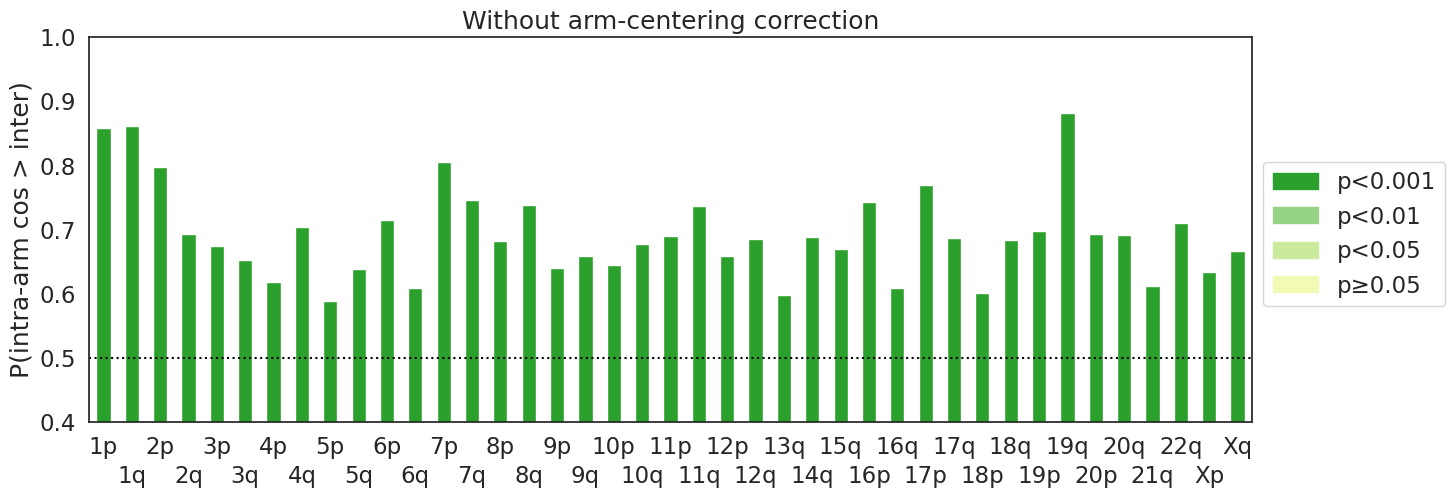

In [30]:
plot_bm_arm_bars(
    jump_bm_arm,
    palette="YlGn_r",
    title="Without arm-centering correction",
    f_name=os.path.join(path, "jump_bm_bars.svg"),
    fmt="svg",
)

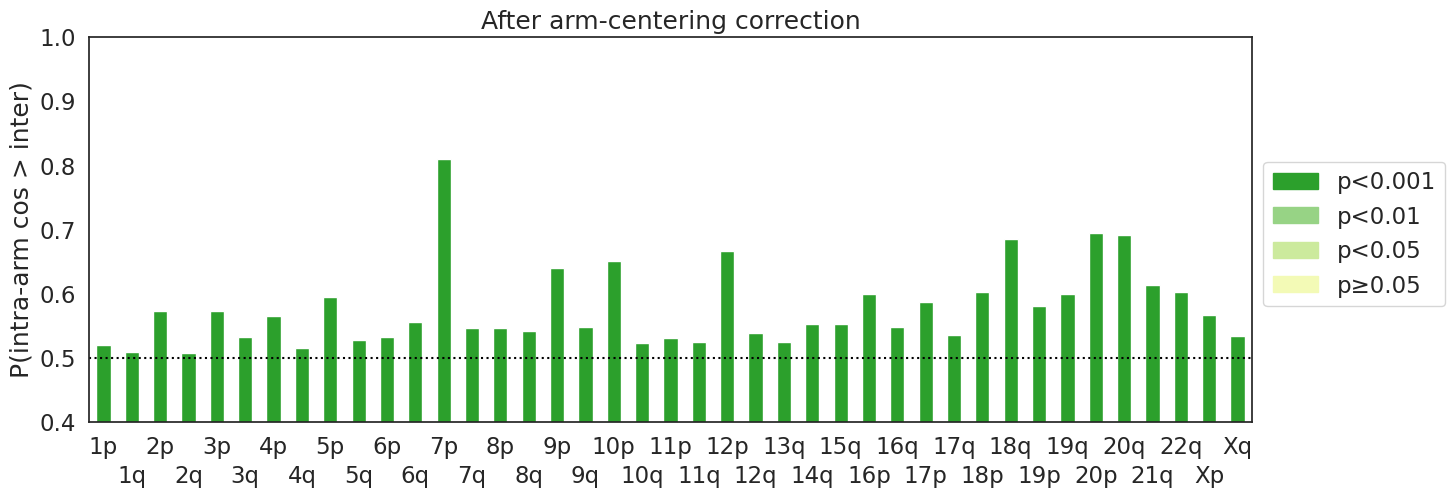

In [31]:
plot_bm_arm_bars(
    jump_pbr_bm_arm,
    palette="YlGn_r",
    title="After arm-centering correction",
    f_name=os.path.join(path, "jump_pbr_bm_bars.svg"),
    fmt="svg",
)

In [32]:
# Combine into one dataframe
tmp1 = jump_bm_arm.copy()
tmp1.index.name = "Chromosome arm"
tmp1 = tmp1.assign(Dataset="cpg0016", Correction="uncorrected")
tmp1 = tmp1.reset_index().set_index(["Dataset", "Correction", "Chromosome arm"])

tmp2 = jump_pbr_bm_arm.copy()
tmp2.index.name = "Chromosome arm"
tmp2 = tmp2.assign(Dataset="cpg0016", Correction="arm-centered")
tmp2 = tmp2.reset_index().set_index(["Dataset", "Correction", "Chromosome arm"])

arm_stats_df = pd.concat([tmp1, tmp2])

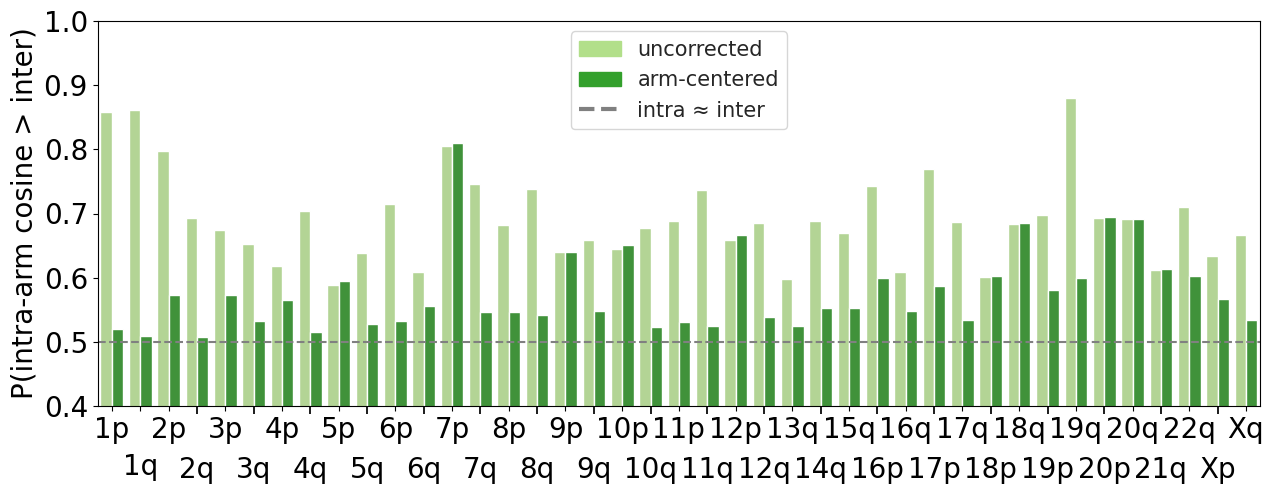

In [33]:
tmp = arm_stats_df.reset_index().rename(columns={"prob": "P(intra-arm cosine > inter)"})
tmp = tmp.replace({"No correction": "uncorrected", "-arm mean": "arm-centered"})
tmp = pd.concat([tmp.query('Correction=="uncorrected"'), tmp.query('Correction=="arm-centered"')])
plot_bm_bar_pairs(
    tmp,
    x="Chromosome arm",
    y="P(intra-arm cosine > inter)",
    hue="Correction",
    lab1="uncorrected",
    lab2="arm-centered",
    f_name=os.path.join(path, "cpg0016_pbr_bars.svg"),
    i=1,
)

# Centromere-to-telomere trend

In [34]:
from proxbias.metrics import compute_gene_bm_metrics, compute_bm_centro_telo_rank_correlations
from proxbias.plotting.centro_telo_scatter import plot_centromere_telomere_scatterplots
from proxbias.plotting.bm_bars import plot_stat_arm_bars

In [35]:
bm_per_gene_df = compute_gene_bm_metrics(jump_mat)

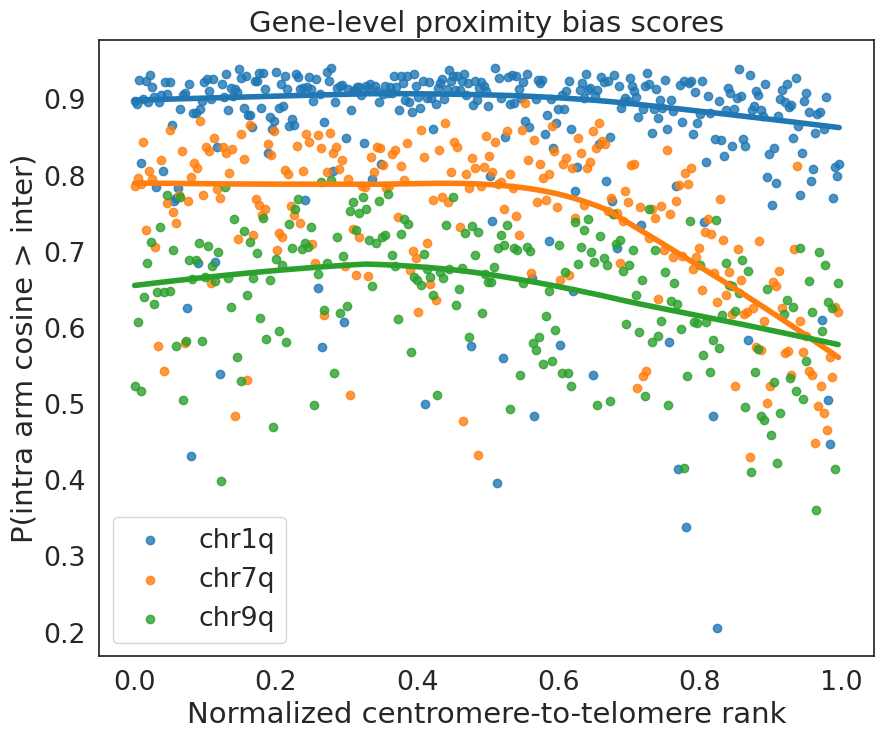

In [36]:
plot_centromere_telomere_scatterplots(
    bm_per_gene_df,
    arms_to_plot=["1q", "7q", "9q"],
    f_name=os.path.join(path, "cpg0016_bm_centro_telo_scatter.svg"),
    fmt="svg",
)

In [37]:
arm_corr_df, arm_corr_sample_sizes_table = compute_bm_centro_telo_rank_correlations(bm_per_gene_df)

In [38]:
arm_corr_sample_sizes_table.to_csv("cpg0016_per_arm_spearman_sample_sizes.csv")

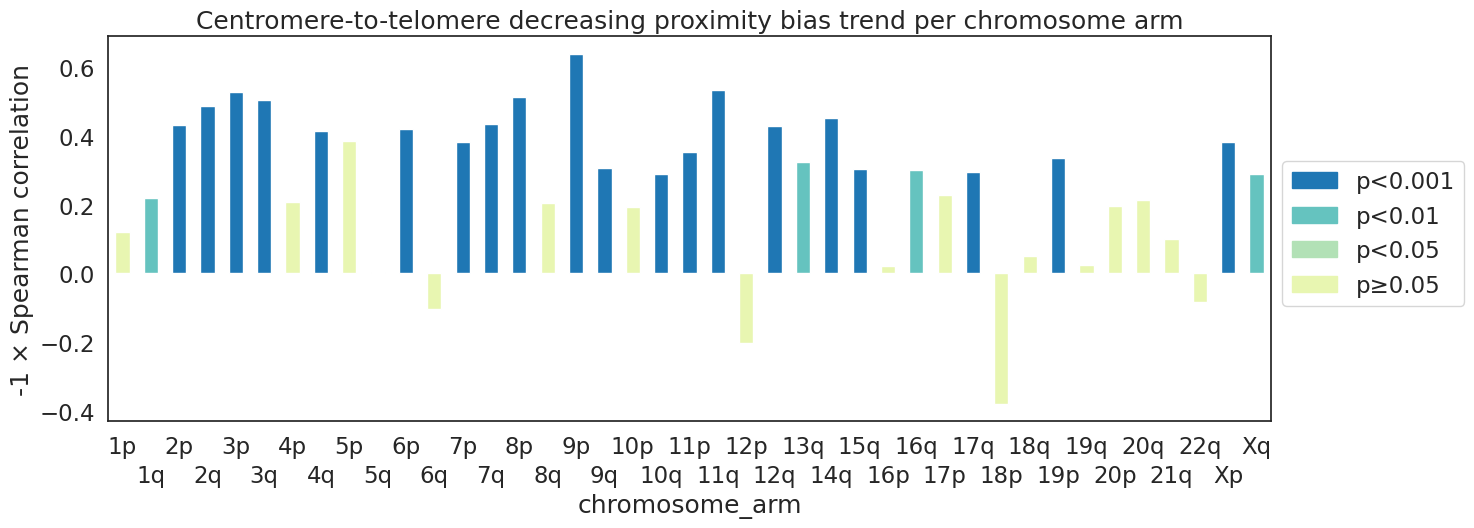

In [39]:
plot_stat_arm_bars(
    arm_corr_df,
    title="Centromere-to-telomere decreasing proximity bias trend per chromosome arm",
    ylabel="-1 × Spearman correlation",
    stat_col="neg_corr",
    pval_col="bonf_p",
    f_name=os.path.join(path, "cpg0016_arm_spearman_corrs.svg"),
    fmt="svg",
);